# EMPS

EMPS, for Electro-Mechanical Positioning System, refers to one of the nonlinear system identification benchmarks on http://nonlinearbenchmark.org/#EMPS. 
It is a set of measurements of a drive system for prismatic joints of robots and/or machine tools.

Let $x(t)$ be the position of the joint, with $x'(t)$ and $x''(t)$ its velocity and acceleration. The Inverse Dynamical Model (IDM) of the system is described by the following differential equation:

$$\begin{align}
\tau_{\text{IDM}}(t) = M x''(t) + F_v x'(t) + F_c \text{sign}(x'(t)) + \mathrm{c}
\end{align}$$

where $\tau_{\text{IDM}}(t)$ is the torque/force on the joint offset by $\mathrm{c}$. The dynamical parameters $M$, $F_v$ and $F_c$ refer to inertia, viscous friction and Coulomb friction. The Direct Dynamical Model (DDM) is a re-expression of the above differential into one as a function of acceleration:

$$\begin{align}
x''(t) = -\frac{F_v}{M} x'(t) -\frac{F_c}{M} \text{sign}(x'(t)) - \frac{\tau_{\text{IDM}}(t)}{M} - \frac{\mathrm{c}}{M}
\end{align}$$

...

The process noise is a Wiener process, where the increment is Gaussian distributed:

$$\begin{align}
w(t) =&\ \frac{d B(t)}{dt} \sim \mathcal{N}(0, \tau^{-1}dt)
\end{align}$$

The parameter $\tau$ represents the precision of the process. The same holds for the measurement noise.

## Solution steps

### 1. Discretize using finite-differences

I'm using an implicit method, for stability reasons.
The backward difference for both derivative terms:

$$\begin{align}
x''(t) \approx&\ \frac{x(t) - 2x(t-h) + x(t-2h)}{h^2} = \frac{x_t - 2x_{t-1} + x_{t-2}}{(\Delta t)^2}\\
x'(t) \approx&\ \frac{x(t) - x(t-h)}{h} = \frac{x_t - x_{t-1}}{\Delta t}\\
\end{align}$$

where $\Delta t = t - (t-1) = 1$. A discretization of the Wiener process yields:

$$\begin{align}
w(t) = \frac{dB(t)}{dt} \approx \frac{B(t) - B(t-h)}{h} = \frac{B_t - B_{t-1}}{\Delta t} \sim \mathcal{N}(0, \tau^{-1}\Delta t) \, .
\end{align}$$

Let $w_t$ be a sample from $\mathcal{N}(0, \tau^{-1})$. The control signal $u(t)$ was constructed from a discrete signal, converted into an analogue signal through a zero-order-hold filter. That means it's a step-function: constant between any $t$ and $t-1$. Since it is an observed variable, we can just convert $u(t)$ straight to $u_t$. The DE can now be written as the following discrete-time system:

$$m (x_t - 2x_{t-1} + x_{t-2}) + v (x_t - x_{t-1}) + a x_t = u_t + w_t$$

Re-writing this in terms of $x_t$ yields:
$$\begin{align}
(m + v + a) x_t&\ + (-2m - v) x_{t-1} + m x_{t-2} = u_t + w_t \\
% x_t + \frac{-2m - v}{m + v + a} x_{t-1} + \frac{m}{m + v + a} x_{t-2} =&\ \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \\
x_t&\ = \frac{2m + v}{m + v + a} x_{t-1} + \frac{-m}{m + v + a} x_{t-2} + \frac{1}{m + v + a} u_t + \frac{1}{m + v + a} w_t \, .
\end{align}$$


### 3. Substitute variables:

I'm substituting variables to clean the equation up a bit:

$$\begin{align} 
\theta_1 =&\ \frac{2m + v}{m + v + a} \\
\theta_2 =&\ \frac{-m}{m + v + a} \\
\eta =&\ \frac{1}{m + v + a} \, .
\end{align}$$

This produces:
$$\begin{align}
x_t = \theta_1 x_{t-1} + \theta_2 x_{t-2} + \eta u_t + \eta w_t
\end{align}$$

I'm going to absorb $\eta$ into $w_t$ (using $\mathbb{V}[aX] = a^2\mathbb{V}[X]$):

$$\begin{align}
\mathbb{V}[\eta w_t] = \eta^2 \mathbb{V}[w_t] = \eta^2 \tau^{-1}
\end{align}$$

I will rename $\eta^2 \tau^{-1}$ as $\gamma^{-1}$. This yields

$$\begin{align}
x_t = \theta_1 x_{t-1} + \theta_2 x_{t-2} + \eta u_t + \tilde{w}_t
\end{align}$$

where $\tilde{w}_t \sim \mathcal{N}(0, \gamma^{-1})$. Given four equations and four unknowns, I can recover $m$, $v$, $a$ and $\tau$ from $\theta_1$, $\theta_2$, $\eta$ and $\gamma$.

### 4. Cast to multivariate first-order form

The system now resembles an auto-regressive process:

$$ \underbrace{\begin{bmatrix} x_t \\ x_{t-1} \end{bmatrix}}_{z_t} = \underbrace{\begin{bmatrix} \theta_1 & \theta_2 \\ 1 & 0 \end{bmatrix}}_{A(\theta)} \underbrace{\begin{bmatrix} x_{t-1} \\ x_{t-2} \end{bmatrix}}_{z_{t-1}} + \underbrace{\begin{bmatrix} \eta \\ 0 \end{bmatrix}}_{B(\eta)} u_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \tilde{w}_t \, .$$

Note that we need a two-dimensional state prior now (reminiscent of adding an initial condition on the velocity).

### 5. Convert to Gaussian probability

The state transition maps to

$$z_t \sim \mathcal{N}(A(\theta) z_{t-1} + c\eta u_t, V)$$

where $V = \begin{bmatrix} \gamma^{-1} & 0 \\ 0 & \epsilon \end{bmatrix}$ and $V^{-1} = W = \begin{bmatrix} \gamma & 0 \\ 0 & \epsilon^{-1} \end{bmatrix}$.

The observation likelihood maps to

$$y_t \sim \mathcal{N}(c^{\top} z_t, \xi^{-1})$$

where $c = \begin{bmatrix} 1 & 0 \end{bmatrix}$ and $e_t \sim \mathcal{N}(0, \xi^{-1})$.

### 6. Choose priors

We currently have unknown parameters $\psi = (\theta_1, \theta_2, \eta, \gamma)$. Since they are substitutions, we don't know anything about their support directly. We do know about it indirectly, from the nonlinear combinations of the physical coefficients. We know that mass $m$ and process precision $\gamma$ are strictly positive parameters and that the damping and stiffness coefficients can be both positive and negative. Hence, by examing the nonlinear transform $\psi = G(\phi)$;

$$\begin{align} 
\theta_1 =&\ \frac{2m + v}{m + v + a} \\
\theta_2 =&\ \frac{-m}{m + v + a} \\
\eta =&\ \frac{1}{m + v + a} \\
\gamma^{-1} =&\ \frac{1}{\tau(m + v+ a)^2} \, .
\end{align}$$

we realize that $\theta_1$, $\theta_2$ and $\eta$ can be both positive and negative, but $\gamma$ can only be positive. As such, we choose the following priors:

$$\begin{align}
\theta \sim&\ \mathcal{N}(m^{0}_{\theta}, V^{0}_{\theta}) \\
\eta \sim&\ \mathcal{N}(m^{0}_{\eta}, v^{0}_{\eta}) \\ 
\gamma \sim&\ \Gamma(a^{0}_\gamma, b^{0}_\gamma) 
\end{align}$$

Modeling $\theta = (\theta_1, \theta_2)$ as a joint Gaussian allows for incorporating it into an Autoregressive node.

### 7. Recover physical variables from substituted ones

Since we have four equations and four unknowns, we can perfectly recover point estimates of the physical variables from substituted ones. However, we don't want point estimates, we want posteriors. 

If we approximate $\gamma$ with a log-Normal distribution and then map it to a Gaussian distribution (i.e. model $\log(\gamma)$), we end up with a Gaussian distributed random vector $\psi = [\theta_1, \theta_2, \eta, \log(\gamma)]$. We can perform a Gaussian approximation of the inverse mapping $G^{-1}(\psi)$ using a first-order Taylor expansion:

$$\begin{align}
m_{\phi} \triangleq \mathbb{E}[G^{-1}(\psi)] =&\ G^{-1}(m_{\psi} \\
V_{\phi} \triangleq \mathbb{V}[G^{-1}(\psi)] =&\ J_{\psi}(m_{\psi}) G^{-1}(m_{\psi} J_{\psi}(m_{\psi})^{\top} \, ,
\end{align}$$


Since each component of $\phi$ is Gaussian distributed, we have actually modeled $\log(m)$ and $\log(\tau)$. We still need to map these to log-Normal distributions to recover $m$ and $\tau$.

### Data

Let's first have a look at the data.

In [1]:
using Revise
using CSV
using DataFrames

In [2]:
using Plots
viz = false;

In [ ]:
include("../data/reading_data.jl")

# Load data from
vir, qm = load_EMPS_data()

In [3]:
# Read data from CSV file
df = CSV.read("../data/SNLS80mV.csv", ignoreemptylines=true)
df = select(df, [:V1, :V2])

# Shorthand
input = df[:,1]
output = df[:,2]

# Time horizon
T = size(df, 1);

In [4]:
# Plot every n-th time-point to avoid figure size exploding
n = 10;

In [5]:
# Plot output signal (observed displacement)
if viz  
    p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="response")
    # Plots.savefig(p1, "viz/output_signal.png")
end

In [6]:
# Plot input signal (control)
if viz
    p2 = Plots.scatter(1:n:T, input[1:n:T], color="blue", label="output", markersize=2, size=(1600,800), xlabel="time (t)", ylabel="control")
    # Plots.savefig(p2, "viz/input_signal.png")
end

## Estimating parameters via Bayesian filtering

Implementation with ForneyLab and AR node. The AR node is locally modified from the package LAR (LAR is in dev mode).

In [7]:
using LinearAlgebra
using ForneyLab
using ForneyLab: unsafeMean, unsafeCov, unsafeVar, unsafePrecision
using LAR
using LAR.Node, LAR.Data
using ProgressMeter

In [8]:
using Zygote

function Jacobian(F, x)
    y = F(x)
    n = length(y)
    m = length(x)
    T = eltype(y)
    j = Array{T, 2}(undef, n, m)
    for i in 1:n
        j[i, :] .= gradient(x -> F(x)[i], x)[1]
    end
    return j
end;

In [9]:
# Start graph
graph = FactorGraph()

# Coefficients
@RV Œ∏ ~ GaussianMeanPrecision(placeholder(:m_Œ∏, dims=(2,)), placeholder(:w_Œ∏, dims=(2,2)))
@RV Œ∑ ~ GaussianMeanPrecision(placeholder(:m_Œ∑), placeholder(:w_Œ∑))
@RV Œ≥ ~ Gamma(placeholder(:a_Œ≥), placeholder(:b_Œ≥))
@RV Œæ ~ Gamma(placeholder(:a_Œæ), placeholder(:b_Œæ))

# State prior
@RV z_t ~ GaussianMeanPrecision(placeholder(:m_z, dims=(2,)), placeholder(:w_z, dims=(2, 2)), id=:z_t)

# Autoregressive node
@RV x_t ~ AutoregressiveControl(Œ∏, z_t, Œ∑, placeholder(:u_t), Œ≥, id=:x_t)

# Specify likelihood
@RV y_t ~ GaussianMeanPrecision(dot([1., 0.], x_t), Œæ, id=:y_t)

# Placeholder for observation
placeholder(y_t, :y_t)

# Draw time-slice subgraph
ForneyLab.draw(graph)

# Inference algorithm
q = PosteriorFactorization(z_t, x_t, Œ∏, Œ∑, Œ≥, Œæ, ids=[:z, :x, :Œ∏, :Œ∑, :Œ≥, :Œæ])
algo = variationalAlgorithm(q, free_energy=false)
source_code = algorithmSourceCode(algo, free_energy=false)
eval(Meta.parse(source_code));
# println(source_code)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
 "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Generated by graphviz version 2.40.1 (20161225.0304)
 -->
<!-- Title: G Pages: 1 -->
 
 
 G 
 
<!-- 4372938730193765200 -->
 
 4372938730193765200 
 
 placeholder_w_Œ∑ 
 
<!-- 5155390594028910506 -->
 
 5155390594028910506 
 
 placeholder_a_Œ≥ 
 
<!-- 5965593057583336056 -->
 
 5965593057583336056 
 
 clamp_1 
 
<!-- 974897862585897564 -->
 
 974897862585897564 
 
 placeholder_w_z 
 
<!-- 10869351449930975717 -->
 
 10869351449930975717 
 
 placeholder_y_t 
 
<!-- 3130963116686438194 -->
 
 3130963116686438194 
 
 ùí© 
 y_t 
 
<!-- 10869351449930975717--3130963116686438194 -->
 
 10869351449930975717--3130963116686438194 
 
 y_t 
 1 out 
 1 out 
 
<!-- 507259847494689068 -->
 
 507259847494689068 
 
 placeholder_u_t 
 
<!-- 12901417086708944409 -->
 
 12901417086708944409 
 
 ùí© 
 z_t 
 
<!-- 12901417086708944409--974897862585897564 -->
 
 12901417086708944409--974897862585897564 
 
 w_z 
 1 out 
 3 w 
 
<!-- 15664476905614087704 -->
 
 15664476905614087704 
 
 placeholder_m_z 
 
<!-- 12901417086708944409--15664476905614087704 -->
 
 12901417086708944409--15664476905614087704 
 
 m_z 
 1 out 
 2 m 
 
<!-- 66688321178530576 -->
 
 66688321178530576 
 
 placeholder_b_Œæ 
 
<!-- 17420075374215898107 -->
 
 17420075374215898107 
 
 placeholder_w_Œ∏ 
 
<!-- 16511655531694601078 -->
 
 16511655531694601078 
 
 Gam 
 gamma_2 
 
<!-- 3130963116686438194--16511655531694601078 -->
 
 3130963116686438194--16511655531694601078 
 
 Œæ 
 1 out 
 3 w 
 
<!-- 17310860890131676722 -->
 
 17310860890131676722 
 
 dot 
 dotproduct_1 
 
<!-- 3130963116686438194--17310860890131676722 -->
 
 3130963116686438194--17310860890131676722 
 
 variable_1 
 1 out 
 2 m 
 
<!-- 16511655531694601078--66688321178530576 -->
 
 16511655531694601078--66688321178530576 
 
 b_Œæ 
 1 out 
 3 b 
 
<!-- 13777161836993324216 -->
 
 13777161836993324216 
 
 placeholder_a_Œæ 
 
<!-- 16511655531694601078--13777161836993324216 -->
 
 16511655531694601078--13777161836993324216 
 
 a_Œæ 
 1 out 
 2 a 
 
<!-- 8332889240445032724 -->
 
 8332889240445032724 
 
 Gam 
 gamma_1 
 
<!-- 8332889240445032724--5155390594028910506 -->
 
 8332889240445032724--5155390594028910506 
 
 a_Œ≥ 
 1 out 
 2 a 
 
<!-- 4957751497648467778 -->
 
 4957751497648467778 
 
 placeholder_b_Œ≥ 
 
<!-- 8332889240445032724--4957751497648467778 -->
 
 8332889240445032724--4957751497648467778 
 
 b_Œ≥ 
 1 out 
 3 b 
 
<!-- 11887615146236123588 -->
 
 11887615146236123588 
 
 placeholder_m_Œ∏ 
 
<!-- 14326117481144408936 -->
 
 14326117481144408936 
 
 ùí© 
 gaussianmeanprecision_1 
 
<!-- 14326117481144408936--17420075374215898107 -->
 
 14326117481144408936--17420075374215898107 
 
 w_Œ∏ 
 1 out 
 3 w 
 
<!-- 14326117481144408936--11887615146236123588 -->
 
 14326117481144408936--11887615146236123588 
 
 m_Œ∏ 
 1 out 
 2 m 
 
<!-- 1155357906522692433 -->
 
 1155357906522692433 
 
 ARC 
 x_t 
 
<!-- 1155357906522692433--507259847494689068 -->
 
 1155357906522692433--507259847494689068 
 
 u_t 
 1 out 
 5 u 
 
<!-- 1155357906522692433--12901417086708944409 -->
 
 1155357906522692433--12901417086708944409 
 
 z_t 
 1 out 
 2 x 
 
<!-- 1155357906522692433--8332889240445032724 -->
 
 1155357906522692433--8332889240445032724 
 
 Œ≥ 
 1 out 
 6 Œ≥ 
 
<!-- 1155357906522692433--14326117481144408936 -->
 
 1155357906522692433--14326117481144408936 
 
 Œ∏ 
 1 out 
 3 Œ∏ 
 
<!-- 17097587067285158355 -->
 
 17097587067285158355 
 
 ùí© 
 gaussianmeanprecision_2 
 
<!-- 1155357906522692433--17097587067285158355 -->
 
 1155357906522692433--17097587067285158355 
 
 Œ∑ 
 1 out 
 4 Œ∑ 
 
<!-- 17097587067285158355--4372938730193765200 -->
 
 17097587067285158355--4372938730193765200 
 
 w_Œ∑ 
 1 out 
 3 w 
 
<!-- 13134787651528001666 -->
 
 13134787651528001666 
 
 placeholder_m_Œ∑ 
 
<!-- 17097587067285158355--13134787651528001666 -->
 
 17097587067285158355--13

In [10]:
# Looking at only the first few timepoints
# T = 100
T = size(df, 1);

# Inference parameters
num_iterations = 10

# Initialize marginal distribution and observed data dictionaries
data = Dict()
marginals = Dict()

# Initialize arrays of parameterizations
params_x = (zeros(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_Œ∏ = (ones(2,T+1), repeat(.1 .*float(eye(2)), outer=(1,1,T+1)))
params_Œ∑ = (ones(1,T+1), .1*ones(1,T+1))
params_Œ≥ = (ones(1,T+1), ones(1,T+1))
params_Œæ = (1e2*ones(1,T+1), 1e0*ones(1,T+1))

# Initialize physical coefficient estimate arrays
params_m = (zeros(T,), zeros(T,))
params_v = (zeros(T,), zeros(T,))
params_a = (zeros(T,), zeros(T,))
params_œÑ = (zeros(T,), zeros(T,))


# Start progress bar
p = Progress(T, 1, "At time ")

# Perform inference at each time-step
for t = 1:T

    # Update progress bar
    update!(p, t)
    
    "Filtering"

    # Initialize marginals
    marginals[:x_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:z_t] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_x[1][:,t], w=params_x[2][:,:,t])
    marginals[:Œ∏] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=params_Œ∏[1][:,t], w=params_Œ∏[2][:,:,t])
    marginals[:Œ∑] = ProbabilityDistribution(Univariate, GaussianMeanPrecision, m=params_Œ∑[1][1,t], w=params_Œ∑[2][1,t])
    marginals[:Œ≥] = ProbabilityDistribution(Univariate, Gamma, a=params_Œ≥[1][1,t], b=params_Œ≥[2][1,t])
    marginals[:Œæ] = ProbabilityDistribution(Univariate, Gamma, a=params_Œæ[1][1,t], b=params_Œæ[2][1,t])
    
    # Set clamped variables
    data = Dict(:y_t => output[t],
                :u_t => input[t],
                :m_z => params_x[1][:,t],
                :w_z => params_x[2][:,:,t],
                :m_Œ∏ => params_Œ∏[1][:,t],
                :w_Œ∏ => params_Œ∏[2][:,:,t],
                :m_Œ∑ => params_Œ∑[1][1,t],
                :w_Œ∑ => params_Œ∑[2][1,t],
                :a_Œ≥ => params_Œ≥[1][1,t],
                :b_Œ≥ => params_Œ≥[2][1,t],
                :a_Œæ => params_Œæ[1][1,t],
                :b_Œæ => params_Œæ[2][1,t])
    
    # Iterate variational parameter updates
    for i = 1:num_iterations

        stepx!(data, marginals)
        stepŒ∏!(data, marginals)
        stepŒ∑!(data, marginals)
        stepŒ≥!(data, marginals)
        stepŒæ!(data, marginals)
    end
    
    # Store current parameterizations of marginals
    params_x[1][:,t+1] = mean(marginals[:x_t])
    params_x[2][:,:,t+1] = marginals[:x_t].params[:w]
    params_Œ∏[1][:,t+1] = mean(marginals[:Œ∏])
    params_Œ∏[2][:,:,t+1] = marginals[:Œ∏].params[:w]
    params_Œ∑[1][1,t+1] = mean(marginals[:Œ∑])
    params_Œ∑[2][1,t+1] = marginals[:Œ∑].params[:w]
    params_Œ≥[1][1,t+1] = marginals[:Œ≥].params[:a]
    params_Œ≥[2][1,t+1] = marginals[:Œ≥].params[:b]
    params_Œæ[1][1,t+1] = marginals[:Œæ].params[:a]
    params_Œæ[2][1,t+1] = marginals[:Œæ].params[:b]
    
    "Map substituted to physical variables via first-order Taylor"
    
    # Approximate gamma with log-normal via moment-matching
    EŒ≥ = unsafeMean(marginals[:Œ≥])
    VŒ≥ = unsafeVar(marginals[:Œ≥])
    m_Œ≥ = log(EŒ≥^2/sqrt(VŒ≥ + EŒ≥^2))
    v_Œ≥ = log(VŒ≥/EŒ≥^2 + 1)

    # Construct vector of parameter estimates œà
    m_œà = [unsafeMean(marginals[:Œ∏])[1], unsafeMean(marginals[:Œ∏])[2], unsafeMean(marginals[:Œ∑])[1], m_Œ≥]
#     V_œà = unsafeCov(marginals[:Œ∏])Diagonal([var(marginals[:Œ∏])[1], var(marginals[:Œ∏])[2], var(marginals[:Œ∑])[1], v_Œ≥])
    V_œà = [unsafeCov(marginals[:Œ∏]) zeros(2,2); zeros(2,2) [unsafeCov(marginals[:Œ∑])[1,1] 0;0 v_Œ≥]]

    # Transformation: œà = G(œï) => œï = G_inv(œà)
    G_inv(œà) = [-œà[2]/œà[3], (œà[1] + 2*œà[2])/œà[3], (-œà[1] -œà[2] +1)/œà[3], œà[4]/œà[3]^2]
    
    # Compute Jacobian of transformation 
    J_mœï = Jacobian(G_inv, m_œà)
    
    # Compute moments of transformed Gaussian using first-order Taylor approx
    m_œï = G_inv(m_œà)
    V_œï = J_mœï*V_œà*J_mœï'

    # Split œï into physical coefficients
    m_m, m_v, m_a, m_œÑ = m_œï
    v_m, v_v, v_a, v_œÑ = Diagonal(V_œï)
    
    # Store param estimates for mass
    params_m[1][t] = m_m
    params_m[2][t] = v_m
    
    # Store param estimates for friction
    params_v[1][t] = m_v
    params_v[2][t] = v_v
    
    # Store param estimates for linear stiffness
    params_a[1][t] = m_a
    params_a[2][t] = v_a
    
    # Store param estimates for process precision
    params_œÑ[1][t] = m_œÑ
    params_œÑ[2][t] = v_œÑ

end

At time 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| Time: 0:04:2139m


### Visualize results

In [11]:
# Plot every n-th time-point to avoid large figure filesizes
n = 20;

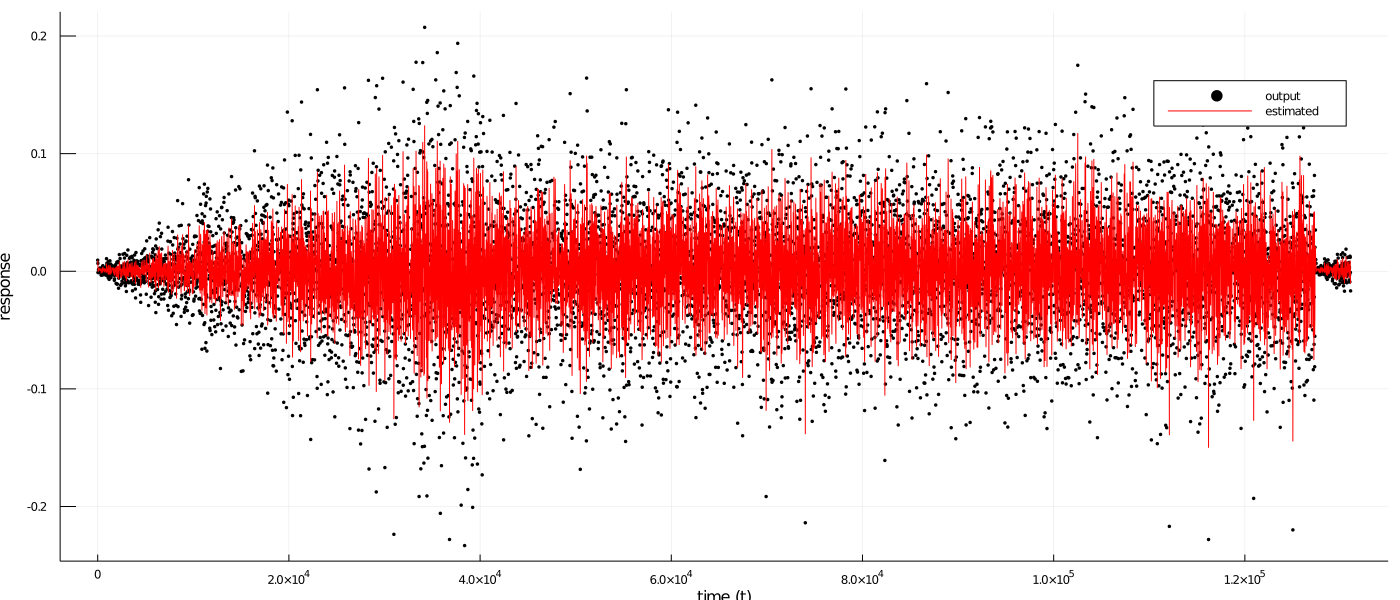

In [12]:
# Plot estimated states
p1 = Plots.scatter(1:n:T, output[1:n:T], color="black", label="output", markersize=2, size=(1400,600), xlabel="time (t)", ylabel="response")
Plots.plot!(1:n:T, params_x[1][1,2:n:end], color="red", linewidth=1, label="estimated")
# Plots.savefig(p1, "viz/estimated_states01.png")

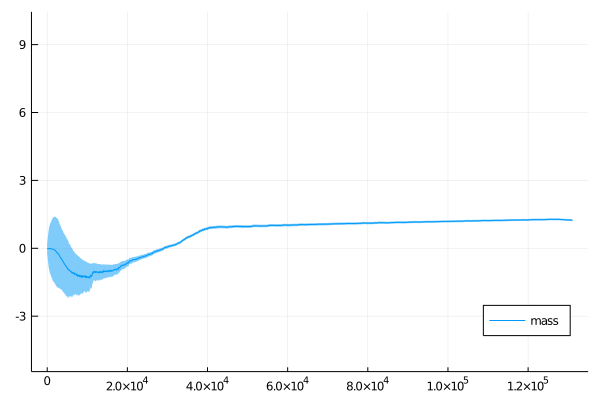

In [13]:
# Visualize estimates of mass
plot(1:n:T, params_m[1][2:n:T], ribbon=[sqrt.(params_m[2][2:n:T]) sqrt.(params_m[2][2:n:T])], label="mass", legend=:bottomright, ylim=[-5.,10.])

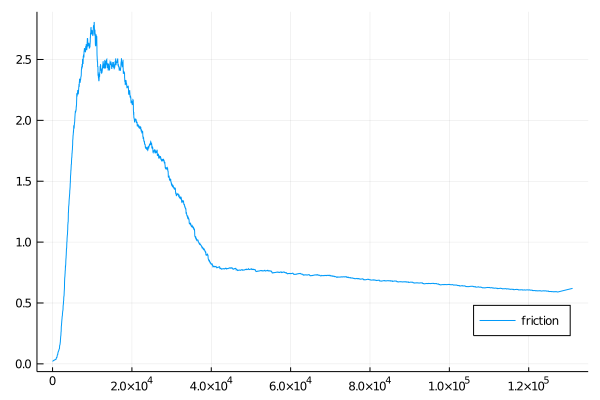

In [14]:
# Visualize estimates of friction
plot(1:n:T, params_v[1][1:n:T], ribbon=[sqrt.(params_v[2][1:n:T]) sqrt.(params_v[2][1:n:T])], label="friction", legend=:bottomright)

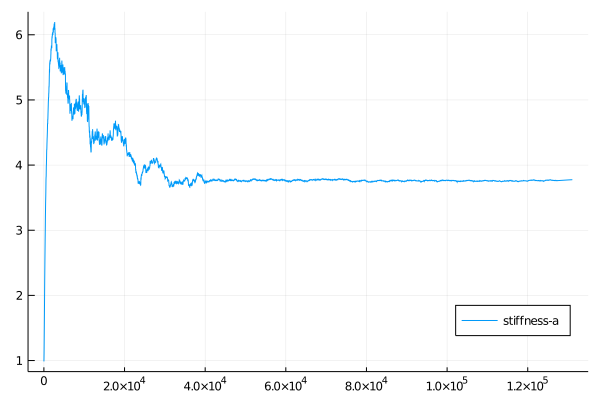

In [15]:
# Visualize estimates of linear stiffness
plot(1:n:T, params_a[1][1:n:T], ribbon=[sqrt.(params_a[2][1:n:T]) sqrt.(params_a[2][1:n:T])], label="stiffness-a", legend=:bottomright)

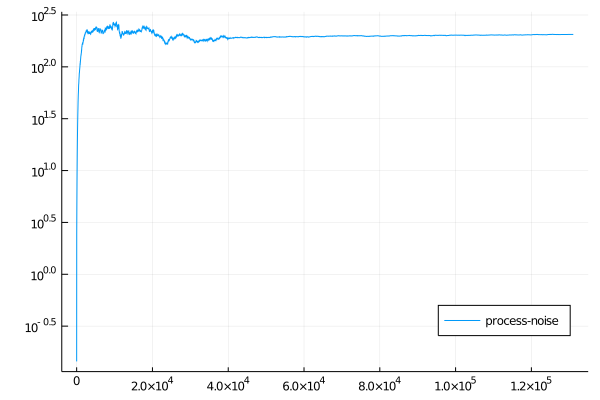

In [16]:
# Visualize estimates of process noise
plot(1:n:T, params_œÑ[1][1:n:T], ribbon=[sqrt.(params_œÑ[2][1:n:T]) sqrt.(params_œÑ[2][1:n:T])], label="process-noise", legend=:bottomright, yscale=:log10)

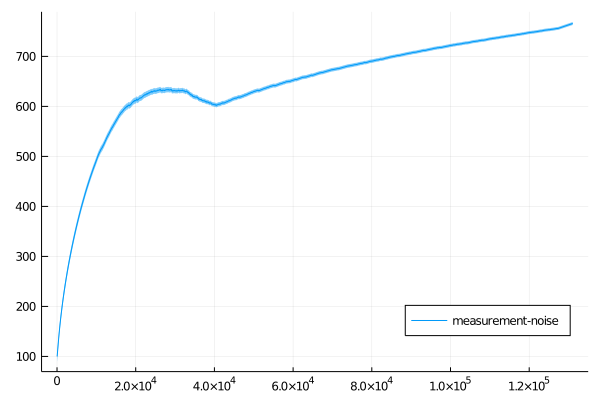

In [17]:
# Visualize estimates of measurement noise
mean_Œæ_inv = params_Œæ[1] ./ params_Œæ[2]
var_Œæ_inv = params_Œæ[1] ./ params_Œæ[2].^2
plot(1:n:T, mean_Œæ_inv[1:n:T], ribbon=[sqrt.(var_Œæ_inv[1:n:T]) sqrt.(var_Œæ_inv[1:n:T])], label="measurement-noise", legend=:bottomright)